In [1]:
import pandas as pd
##Pre-processing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

#Model Evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, roc_auc_score,precision_score,recall_score,f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from scipy.sparse import csr_matrix, hstack
from scipy.stats import ks_2samp


#Model Building
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn import model_selection
import xgboost as xgb

#All Purpose
import numpy as np
import pickle
import seaborn as sns
import warnings
import joblib
import matplotlib.pyplot as plt

%matplotlib inline
warnings.filterwarnings("ignore")

E:\Softwares\Anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
path = 'E:\\Shobhit\\MSDS\\Capstone\\Y1_Capstone\\data\\final_data'
df_s2_data = pd.read_csv(f'{path}\\train_test_scenario_2.csv') #Reading Scenario 2 data

In [3]:
print(df_s2_data.shape)
df_s2_data.head()

(51239, 6)


,device_id,phone_brand,device_model,gender,age,train_test_flag
0,398514470209561000,Huawei,è£è€€ç•…çŽ©4X,M,68,train
1,-3073918292047050000,Huawei,è£è€€ç•…çŽ©4C,M,27,train
2,5805880616488060000,lshi,è¶…çº§æ‰‹æœº1,M,39,train
3,-2403560729305410000,nibilu,ç«æ˜Ÿä¸€å·,M,25,train
4,-1889893391998300000,Huawei,è£è€€3Xç•…çŽ©ç‰ˆ,M,22,train


In [4]:
df_s2_data.dtypes

device_id           int64
phone_brand        object
device_model       object
gender             object
age                 int64
train_test_flag    object
dtype: object

##### Encoding Categorical Variables

- For encoding categorical variables we would be encoding them using one-hot encoder.

In [5]:
def perform_data_encoding(data):
    df_data_enc = data.copy()
    
    df_data_temp = data.drop(columns= ['gender','age','device_id','train_test_flag'],axis=1)
    cols = list(df_data_temp.columns)
    
    #One hot encoding categorical variables
    enc = preprocessing.OneHotEncoder(sparse=False)
    enc.fit(df_data_enc[cols])
    enc_data = enc.transform(df_data_enc[cols]) 
    df_enc = pd.DataFrame(enc_data,columns = enc.get_feature_names_out(cols))
    enocoded_column_names = df_enc.columns
    print(df_enc.shape)
    
    #For columns one hot encoded have to be removed from the dataframe
    print(f'Before Dropping:{df_data_enc.shape}')
    print(cols)
    df_data_enc.drop(columns = cols,axis=1,inplace=True)
    print(f'After Dropping:{df_data_enc.shape}')
    
    #Merging the encoded data with the original dataframe
    print(f'Before encoding:{df_enc.shape}')
    df_data_enc = pd.concat([df_data_enc,df_enc],axis=1)
    print(f'After encoding:{df_data_enc.shape}')
    
    return df_data_enc, enocoded_column_names

In [6]:
df_s2_data_enc, categorical_columns = perform_data_encoding(df_s2_data)

(51239, 1469)
Before Dropping:(51239, 6)
['phone_brand', 'device_model']
After Dropping:(51239, 4)
Before encoding:(51239, 1469)
After encoding:(51239, 1473)


In [7]:
len(categorical_columns)

1469

#### Splitting Data Into Train_Test Split 

In [8]:
#Training Data
df_s2_data_train = df_s2_data_enc[df_s2_data_enc['train_test_flag'] == 'train']
df_s2_data_train.shape

(40988, 1473)

In [9]:
# Saving Training Data
# path = 'E:\\Shobhit\\MSDS\\Capstone\\Y1_Capstone\\MLModels'
# df_s2_data_train.to_csv(f'{path}\\df_s2_data_train.csv', index=False)

In [78]:
#Reading Saved Training Data
# path = 'E:\\Shobhit\\MSDS\\Capstone\\Y1_Capstone\\MLModels'
# df_s2_data_train = pd.read_csv(f'{path}\\df_s2_data_train.csv')
# df_s2_data_train.shape

In [10]:
df_s2_data_train.drop('train_test_flag',axis=1,inplace=True)
df_s2_data_train.shape

(40988, 1472)

In [11]:
#Test Data
df_s2_data_test = df_s2_data_enc[df_s2_data_enc['train_test_flag'] == 'test']
df_s2_data_test.shape

(10251, 1473)

In [12]:
# Saving Test Data
# path = 'E:\\Shobhit\\MSDS\\Capstone\\Y1_Capstone\\MLModels'
# df_s2_data_test.to_csv(f'{path}\\df_s2_data_test.csv', index=False)

In [79]:
#Reading Saved Test Data
# path = 'E:\\Shobhit\\MSDS\\Capstone\\Y1_Capstone\\MLModels'
# df_s2_data_test = pd.read_csv(f'{path}\\df_s2_data_test.csv')
# df_s2_data_test.shape

In [14]:
df_s2_data_test.drop('train_test_flag',axis=1,inplace=True)
df_s2_data_test.shape

(10251, 1472)

In [16]:
#Separating target variables with features for training data
#For Male we would be denoting by 1 and for female by 0
X_train_s2 = df_s2_data_train.drop(columns= ['gender','age','device_id'],axis=1)
Y_train_s2_age = df_s2_data_train['age']
Y_train_s2_gender = df_s2_data_train['gender'].apply(lambda gender : 1 if gender == 'M' else 0)
Y_train_s2_gender
print(X_train_s2.shape)
print(Y_train_s2_age.shape)
print(Y_train_s2_gender.shape)

(40988, 1469)
(40988,)
(40988,)


In [17]:
#Separating target variables with features for test data
X_test_s2 = df_s2_data_test.drop(columns= ['gender','age','device_id'],axis=1)
Y_test_s2_age = df_s2_data_test['age']
Y_test_s2_gender = df_s2_data_test['gender'].apply(lambda gender : 1 if gender == 'M' else 0)
print(X_test_s2.shape)
print(Y_test_s2_age.shape)
print(Y_test_s2_gender.shape)

(10251, 1469)
(10251,)
(10251,)


### Creating Helper Functions for Model Evaluation

In [80]:
#Below dict will contain all the evaluation metrics for each model which would be later used for comparison
model_evaluation_dict_gender = {
    'Model_Name':[],
    'Training_Accuracy':[],
    'Testing_Accuracy':[],
    'Precision_Training':[],
    'Precision_Testing':[],
    'Recall_Training':[],
    'Recall_Testing':[],
    'F1Score_Training':[],
    'F1Score_Testing':[],
    'AUC_Training':[],
    'AUC_Testing':[],
    'KS_Training_Male':[],
    'KS_Testing_Male':[],
    'KS_Training_Female':[],
    'KS_Testing_Female':[],
    'Top3_Probability_Bands_KSTable':[],
    'Bottom3_Probability_Bands_KSTable':[],
}

In [19]:
def plot_and_get_roc_auc_curve(model, data, y_true):
    y_pred = model.predict_proba(data)[:,1]
    fpr, tpr, _ = metrics.roc_curve(y_true,  y_pred)
    auc = metrics.roc_auc_score(y_true, y_pred)
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.title('ROC_AUC_Curve')
    plt.plot([0, 1], [0, 1], color="green", linestyle="--")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

    return auc

In [20]:
def get_top3_bottom3_decile_KS(model, data, y_true):
    probs = model.predict_proba(data)[:,1]
    
    #dataframe with true labels and predicted probabilities
    df = pd.DataFrame({'y_true': y_true, 'y_scores': probs})

    # deciles based on predicted probabilities
    df['decile'] = pd.qcut(df['y_scores'], 10, duplicates='drop', labels=False)

    # group by decile and calculate cumulative percentage of events and non-events
    grouped = df.groupby('decile')
    
    df['min_prob'] = grouped['y_scores'].min()
    df['max_prob'] = grouped['y_scores'].max()
    
    df['cum_event_pct'] = grouped['y_true'].cumsum() / df['y_true'].sum()
    df['cum_nonevent_pct'] = (1 - grouped['y_true'].sum()).cumsum() / (1 - df['y_true']).sum()

    # KS statistic for each decile
    df['KS'] = np.abs(df['cum_event_pct'] - df['cum_nonevent_pct'])

    # identify probability bands for top 3 and bottom 3 deciles
    top_3 = df.nlargest(3, 'KS')
    bottom_3 = df.nsmallest(3, 'KS')

    # print results
    print('Top 3 deciles:')
    print(top_3)
    print('Bottom 3 deciles:')
    print(bottom_3)
    
    return top_3[['min_prob', 'max_prob']], bottom_3[['min_prob', 'max_prob']]

In [21]:
def calculate_KS(model, data, y_true):
    # get the predicted probabilities for the data
    probs = model.predict_proba(data)
    
    # calculate the KS statistic for each class
    ks_0 = ks_2samp(probs[:, 0], y_true) #For Female
    ks_1 = ks_2samp(probs[:, 1], y_true) #For Male
    
    print('KS statistic for class Female:', ks_0)
    print('KS statistic for class Male:', ks_1)
    
    return ks_0, ks_1

In [22]:
def evaluate_model(model, data, y_true, isTraining=True):
    label = 'Training' if isTraining else 'Testing'
    
    print(f'Evaluating {label} performance')
    
    #Prediciting target variable on training data
    y_pred = model.predict(data)
    #Calculating Accuracy
    accuracy = metrics.balanced_accuracy_score(y_true, y_pred)
    print(f'Accuracy:{accuracy}')
    
    #Calculating Precision and Recall Score
    precision = precision_score(y_true, y_pred, average="weighted")
    recall = recall_score(y_true, y_pred, average="weighted")
    print(f'Precision:{precision}')
    print(f'Recall:{recall}')
    
    #Calculating F1-Score
    f1 = f1_score(y_true, y_pred)
    print(f'F1Score:{f1}')
    
    #Plotting Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1])
    disp.plot()
    
#     plt.show()
    
    #Evaluating model using KS Statistic
    ks_0, ks_1 = calculate_KS(model, data, y_true)    
    
    #Adding above generated evaluation metrics to the model_evaluation_dict_gender
    model_evaluation_dict_gender[f'{label}_Accuracy'].append(accuracy)
    model_evaluation_dict_gender[f'Precision_{label}'].append(precision)
    model_evaluation_dict_gender[f'Recall_{label}'].append(recall)
    model_evaluation_dict_gender[f'F1Score_{label}'].append(f1)
    model_evaluation_dict_gender[f'KS_{label}_Male'].append(ks_1)
    model_evaluation_dict_gender[f'KS_{label}_Female'].append(ks_0)
    if isTraining:
        #Getting top3 and bottom3 probability bonds as per KS table
        top3, bottom3 = get_top3_bottom3_decile_KS(model, data, y_true)
        model_evaluation_dict_gender['Top3_Probability_Bands_KSTable'].append(str(top3.values.tolist()))
        model_evaluation_dict_gender['Bottom3_Probability_Bands_KSTable'].append(str(bottom3.values.tolist()))


### Logistic Regression Model for Predicting `Gender` for Scenario 2

- Logistic regression model will be used as a benchmark to compare the other Machine learning models.

In [23]:
Y_train_s2_gender.value_counts()

1    26066
0    14922
Name: gender, dtype: int64

- We have an unbalanced data set as there are more Male labels as compared to Females

In [24]:
#As it is an unbalanced data set compute the appropiate class weight to be assigned to the model
weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(Y_train_s2_gender),y = Y_train_s2_gender)
print(weights)
class_weights = dict(zip(np.unique(Y_train_s2_gender), weights))
print(class_weights)

[1.37340839 0.78623494]
{0: 1.3734083902962069, 1: 0.7862349420701297}


In [25]:
#Declaring the Logistic Regression Model and training the model on the train data
lr_model = LogisticRegression(class_weight = class_weights, random_state=100, max_iter=1500)
lr_model.fit(X_train_s2, Y_train_s2_gender)

LogisticRegression(class_weight={0: 1.3734083902962069, 1: 0.7862349420701297},
                   max_iter=1500, random_state=100)

In [26]:
lr_model.classes_

array([0, 1], dtype=int64)

In [27]:
# Saving the Logistic Regression Model as a pickle in a file
path = 'E:\\Shobhit\\MSDS\\Capstone\\Y1_Capstone\\MLModels'
filename = f'{path}\\Logistic_Regression_Gender_Scenario2.pkl'
pickle.dump(lr_model, open(filename, 'wb'))

In [30]:
# Reading saved Logistic regression model
# path = 'E:\\Shobhit\\MSDS\\Capstone\\Y1_Capstone\\MLModels'
# filename = f'{path}\\Logistic_Regression_Gender_Scenario2.pkl'
# lr_model = pickle.load(open(filename, 'rb'))
# print(lr_model)

LogisticRegression(class_weight={0: 1.3734083902962069, 1: 0.7862349420701297},
                   max_iter=1500, random_state=100)


#### Evaluating the Logistic Regression classifier on Training Data Set

Evaluating Training performance
Accuracy:0.5888217955856965
Precision:0.6176790235582619
Recall:0.6027129891675612
F1Score:0.6719845298525502
KS statistic for class Female: KstestResult(statistic=0.6359422269932663, pvalue=0.0)
KS statistic for class Male: KstestResult(statistic=0.6359422269932663, pvalue=0.0)
Top 3 deciles:
   y_true  y_scores  decile  min_prob  max_prob  cum_event_pct  \
9       1  0.529931       5  0.625405  0.904477       0.000077   
8       1  0.510155       4  0.586393  0.625277       0.000077   
7       1  0.458067       2  0.552236  0.586269       0.000038   

   cum_nonevent_pct        KS  
9         -1.746147  1.746223  
8         -1.517089  1.517166  
7         -1.318523  1.318561  
Bottom 3 deciles:
   y_true  y_scores  decile  min_prob  max_prob  cum_event_pct  \
0       1  0.529931       5  0.093011  0.368687       0.000038   
1       1  0.540934       6  0.368709  0.425991       0.000038   
2       1  0.573133       7  0.426151  0.459902       0.000038  

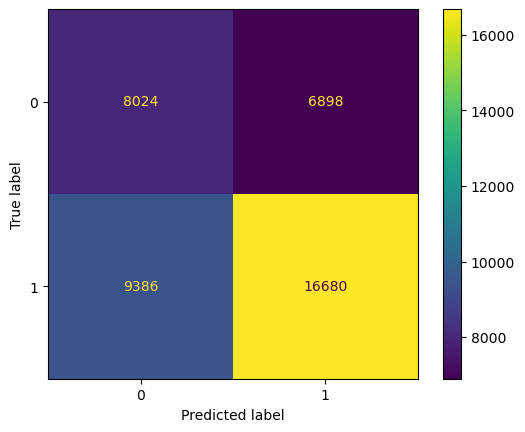

In [81]:
model_evaluation_dict_gender['Model_Name'].append('Logistic_Regression')
evaluate_model(lr_model, X_train_s2, Y_train_s2_gender)

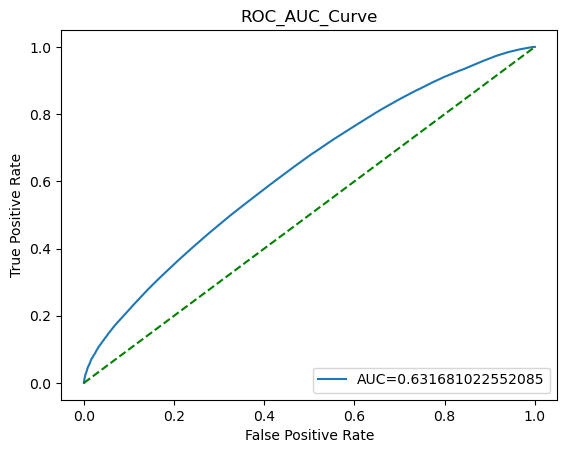

In [82]:
#Calculating the auc score and plotting it for Train Data
auc = plot_and_get_roc_auc_curve(lr_model, X_train_s2, Y_train_s2_gender)
model_evaluation_dict_gender['AUC_Training'].append(auc)

#### Evaluating the Logistic Regression classifier on Test Data Set

Evaluating Testing performance
Accuracy:0.5655741236169187
Precision:0.5966103339623141
Recall:0.5822846551555946
F1Score:0.6562851179964682
KS statistic for class Female: KstestResult(statistic=0.6360355087308556, pvalue=0.0)
KS statistic for class Male: KstestResult(statistic=0.6360355087308556, pvalue=0.0)


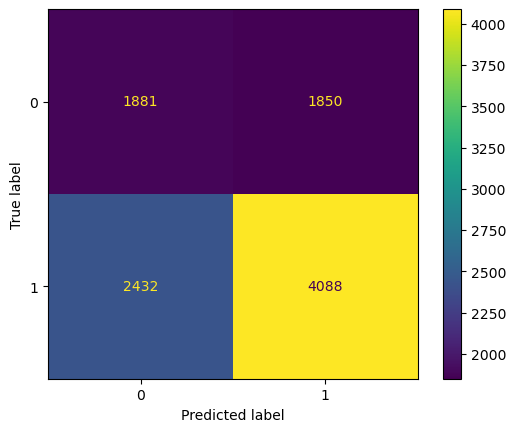

In [83]:
evaluate_model(lr_model, X_test_s2, Y_test_s2_gender, False)

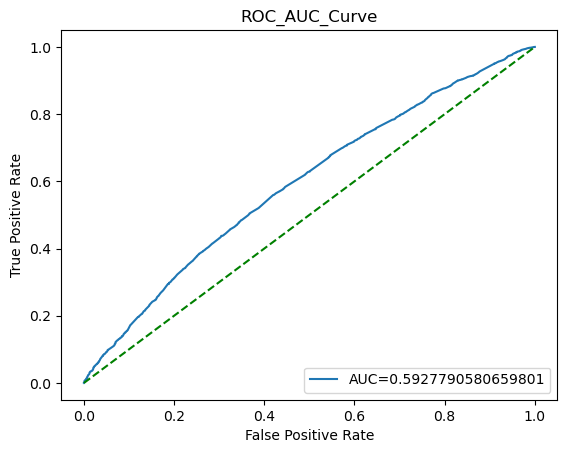

In [84]:
#Calculating the auc score and plotting it for Test Data
auc = plot_and_get_roc_auc_curve(lr_model, X_test_s2, Y_test_s2_gender)
model_evaluation_dict_gender['AUC_Testing'].append(auc)

### XGBoost Model for Predicting `Gender` for Scenario 2

In [35]:
#Training XGBoost Model on train data
xgclf = xgb.XGBClassifier(random_state=100,n_jobs=-1)
xgclf.fit(X_train_s2, Y_train_s2_gender)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=100, ...)

In [36]:
# Saving the XGBoost Model as a pickle in a file
path = 'E:\\Shobhit\\MSDS\\Capstone\\Y1_Capstone\\MLModels'
filename = f'{path}\\XGBoost_Gender_Scenario2.pkl'
pickle.dump(xgclf, open(filename, 'wb'))
print(xgclf)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=100, ...)


In [37]:
# Reading saved XGBoost model
# path = 'E:\\Shobhit\\MSDS\\Capstone\\Y1_Capstone\\MLModels'
# filename = f'{path}\\XGBoost_Gender_Scenario2.pkl'
# xgclf = pickle.load(open(filename, 'rb'))
# print(xgclf)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=100, ...)


#### Evaluating the XGBoost classifier on Training Data Set

Evaluating Training performance
Accuracy:0.519826196557144
Precision:0.6507657231377372
Recall:0.6458719625256173
F1Score:0.7793502880683459
KS statistic for class Female: KstestResult(statistic=0.6359422269932663, pvalue=0.0)
KS statistic for class Male: KstestResult(statistic=0.6359422269932663, pvalue=0.0)
Top 3 deciles:
   y_true  y_scores  decile  min_prob  max_prob  cum_event_pct  \
8       1  0.657944       4  0.707451  0.901014       0.000077   
7       1  0.608327       2  0.677236  0.706869       0.000038   
6       1  0.657944       4  0.664617  0.676339       0.000038   

   cum_nonevent_pct        KS  
8         -1.746214  1.746290  
7         -1.534781  1.534819  
6         -1.335009  1.335047  
Bottom 3 deciles:
   y_true  y_scores  decile  min_prob  max_prob  cum_event_pct  \
0       1   0.66432       5  0.164539  0.542655       0.000038   
1       1   0.66432       5  0.543853  0.571571       0.000077   
2       1   0.66432       5  0.571632  0.608327       0.000115   

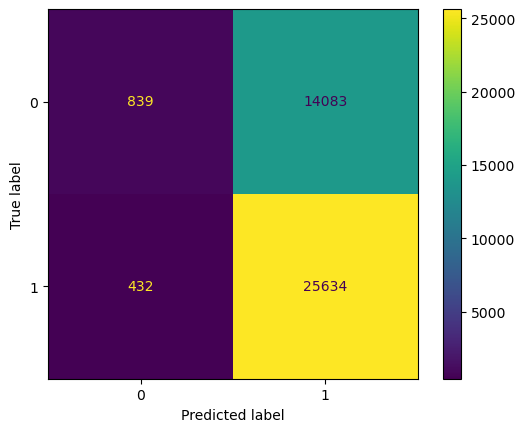

In [85]:
model_evaluation_dict_gender['Model_Name'].append('XGBoost_Basic')
evaluate_model(xgclf, X_train_s2, Y_train_s2_gender)

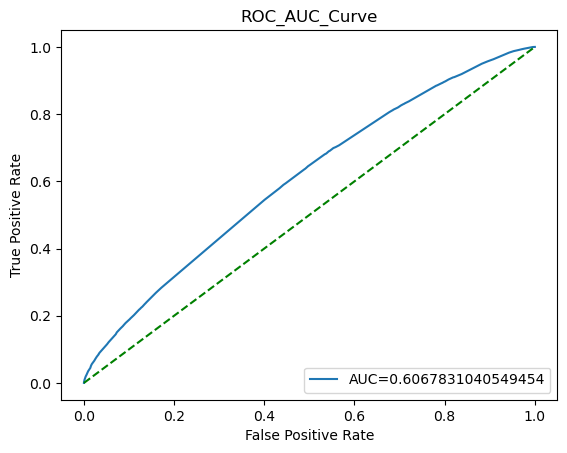

In [86]:
#Calculating the auc score and plotting it for Train Data
auc = plot_and_get_roc_auc_curve(xgclf, X_train_s2, Y_train_s2_gender)
model_evaluation_dict_gender['AUC_Training'].append(auc)

#### Evaluating the XGBoost classifier on Test Data Set

Evaluating Testing performance
Accuracy:0.5143465131307418
Precision:0.6298629673502186
Recall:0.6418885962345137
F1Score:0.777393729913286
KS statistic for class Female: KstestResult(statistic=0.6360355087308556, pvalue=0.0)
KS statistic for class Male: KstestResult(statistic=0.6360355087308556, pvalue=0.0)


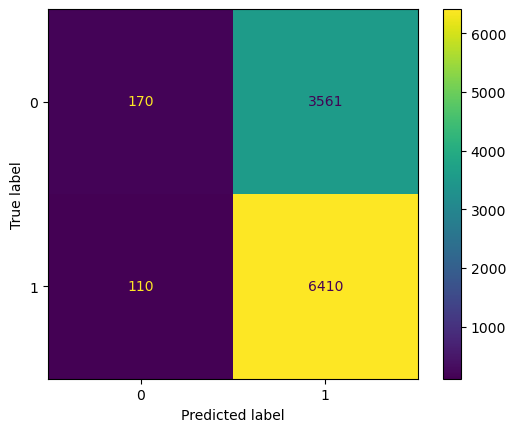

In [87]:
evaluate_model(xgclf, X_test_s2, Y_test_s2_gender, False)

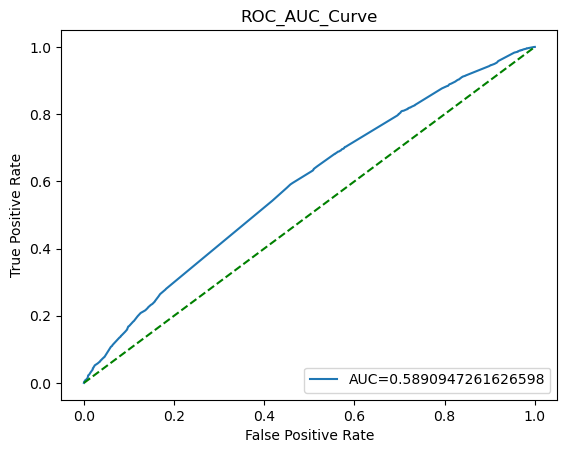

In [88]:
#Calculating the auc score and plotting it for Test Data
auc = plot_and_get_roc_auc_curve(xgclf, X_test_s2, Y_test_s2_gender)
model_evaluation_dict_gender['AUC_Testing'].append(auc)

### HyperParemter Tuning XGBoost Model for Predicting `Gender` for Scenario 2

In [89]:
#StratifiedKFold is used as we want the folds to be created to have the same proportion of class lables as in the data.
cross_validation = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

In [90]:
scorer = metrics.make_scorer(metrics.roc_auc_score,
                             greater_is_better=True,
                             needs_proba=True,
                             needs_threshold=False)

In [44]:
#Creating parameter grid
#Uncomment if running for first time
param_grid = {

    'min_child_weight': [1, 5, 10],

    'gamma': [0.5, 1, 1.5, 2, 5],

    'subsample': [0.6, 0.8, 1.0],

    'colsample_by_tree': [0.6, 0.8, 1.0],

    'max_depth': [3, 4, 5],

    'n_estimators': range(60, 360, 40),

    'learning_rate': [0.1, 0.01, 0.05],

 }

In [45]:
#Training XGBoost Model
xgb_model = xgb.XGBClassifier()
clf_xgb_grid = RandomizedSearchCV(xgb_model,
                              param_grid,
                               cv=cross_validation,
                               scoring=scorer,
                               verbose=4,
                               n_jobs=-1,
                               random_state = 100,
                               error_score="raise")
clf_xgb_grid.fit(X_train_s2, Y_train_s2_gender)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[13:45:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "colsample_by_tree" } are not used.



RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   error_score='raise',
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_...
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_by_tree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'learning_rate': [0.1, 0.01, 0.05],
                                        'max_depth': [3, 4, 5],
                                        'min_child_weight': [1, 5, 10],
                                        'n_estimators': range(60, 360, 40),
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=100,
                   scoring=make_scorer(roc_auc_score, needs_proba=True),
                   verbose=4)

In [46]:
print(clf_xgb_grid.best_params_)
print(clf_xgb_grid.best_score_)
print(clf_xgb_grid.best_estimator_)
best_clf_xgb_grid = clf_xgb_grid.best_estimator_
xgb_hpt = best_clf_xgb_grid

{'subsample': 0.8, 'n_estimators': 180, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 1, 'colsample_by_tree': 0.6}
0.5783271388278606
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_by_tree=0.6, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=180, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)


In [47]:
#Saving the model
#Uncomment below if running for first time and saved model is not present.
path = 'E:\\Shobhit\\MSDS\\Capstone\\Y1_Capstone\\MLModels'
filename = f'{path}\\XGBoostHPT_Gender_Scenario2.pkl'
pickle.dump(best_clf_xgb_grid, open(filename, 'wb'))

In [48]:
#Reading saved model for XGBoost with Grid Search
# path = 'E:\\Shobhit\\MSDS\\Capstone\\Y1_Capstone\\MLModels'
# filename = f'{path}\\XGBoostHPT_Gender_Scenario2.pkl'
# xgb_hpt = pickle.load(open(filename, 'rb'))
# print(xgb_hpt)

#### Evaluating the XGBoost with HyperParameter Tuning classifier on Training Data Set

Evaluating Training performance
Accuracy:0.5129513461250705
Precision:0.6361159331478019
Recall:0.6417910447761194
F1Score:0.7779390420899855
KS statistic for class Female: KstestResult(statistic=0.6360355087308556, pvalue=0.0)
KS statistic for class Male: KstestResult(statistic=0.6360355087308556, pvalue=0.0)
Top 3 deciles:
   y_true  y_scores  decile  min_prob  max_prob  cum_event_pct  \
9       0  0.608196       2  0.706628  0.834208       0.000000   
8       1  0.575212       1  0.680939  0.706326       0.000153   
7       1  0.509794       0  0.669803  0.680565       0.000153   

   cum_nonevent_pct        KS  
9         -1.744841  1.744841  
8         -1.554007  1.554160  
7         -1.344144  1.344297  
Bottom 3 deciles:
   y_true  y_scores  decile  min_prob  max_prob  cum_event_pct  \
0       1  0.634250       3  0.328717  0.545906       0.000153   
1       1  0.663657       6  0.546117  0.575212       0.000153   
2       0  0.647345       4  0.577526  0.614568       0.000000  

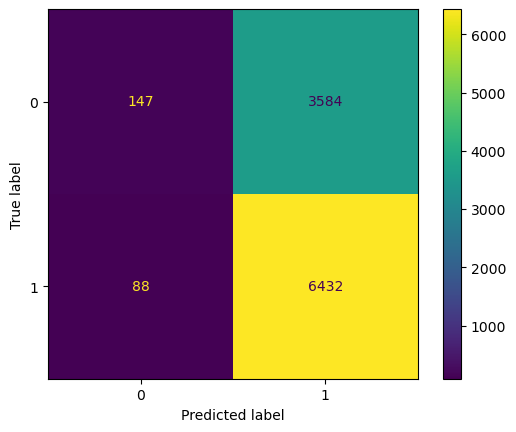

In [91]:
model_evaluation_dict_gender['Model_Name'].append('XGBoost_HPT')
evaluate_model(xgb_hpt, X_test_s2, Y_test_s2_gender)

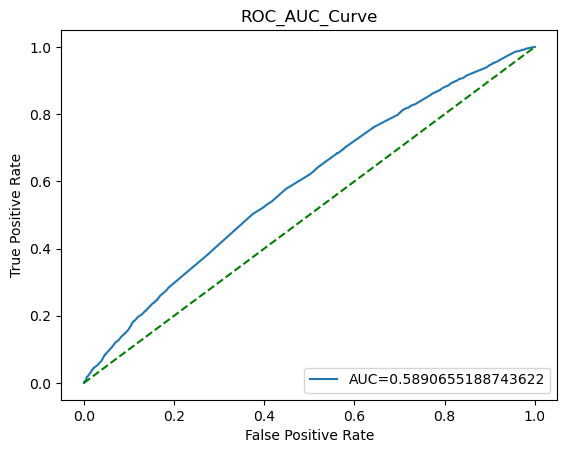

In [92]:
#Calculating the auc score and plotting it for Train Data
auc = plot_and_get_roc_auc_curve(xgb_hpt, X_test_s2, Y_test_s2_gender)
model_evaluation_dict_gender['AUC_Training'].append(auc)

#### Evaluating the XGBoost with Hyper Parameter Tuning on Training Data Set

Evaluating Testing performance
Accuracy:0.5129513461250705
Precision:0.6361159331478019
Recall:0.6417910447761194
F1Score:0.7779390420899855
KS statistic for class Female: KstestResult(statistic=0.6360355087308556, pvalue=0.0)
KS statistic for class Male: KstestResult(statistic=0.6360355087308556, pvalue=0.0)


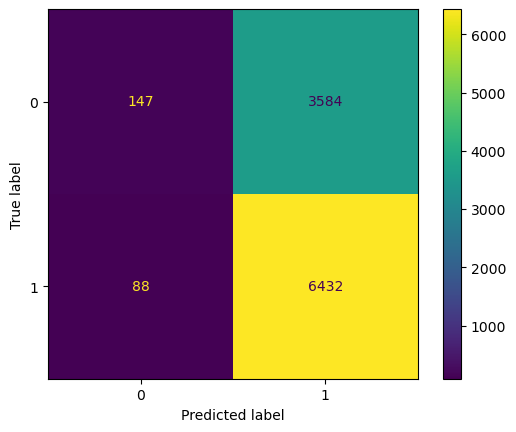

In [93]:
evaluate_model(xgb_hpt, X_test_s2, Y_test_s2_gender, False)

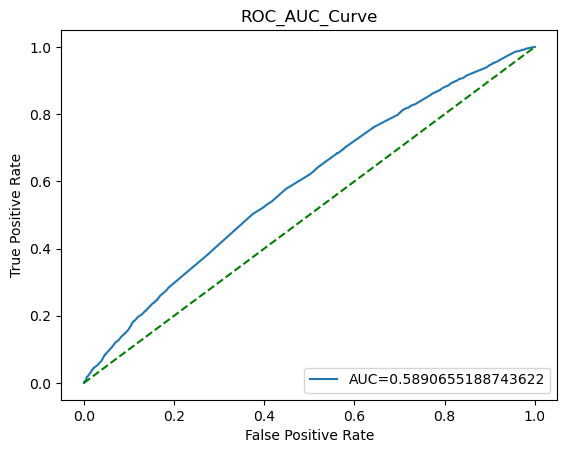

In [94]:
#Calculating the auc score and plotting it for Test Data
auc = plot_and_get_roc_auc_curve(xgb_hpt, X_test_s2, Y_test_s2_gender)
model_evaluation_dict_gender['AUC_Testing'].append(auc)

### Stacking Classifier Model with Grid Search for Predicting `Gender` for Scenario 2

In [54]:
# 1st set of models
clf1 = LogisticRegression(class_weight = class_weights, random_state=100)
clf2 = RandomForestClassifier(class_weight = class_weights,random_state=100,n_jobs=-1)
xgb_m = xgb.XGBClassifier()

stacking_classifier = StackingCVClassifier(classifiers=[clf1, clf2], meta_classifier=xgb_m, use_probas=True, cv=cross_validation, random_state=100)

In [55]:
#Training Stacking Classifier Model on train data
# Performing Cross Validation on Stacking Classifier

for clf, label in zip([clf1, clf2, stacking_classifier], 
                      ['lr', 
                       'Random Forest', 
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, X_train_s2, Y_train_s2_gender, cv=cross_validation, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.57 (+/- 0.01) [lr]
Accuracy: 0.57 (+/- 0.01) [Random Forest]
Accuracy: 0.62 (+/- 0.01) [StackingClassifier]


In [56]:
#Fitting the Stacking Classifier on Training Data
sclf_fit = stacking_classifier.fit(X_train_s2, Y_train_s2_gender)

In [57]:
# Saving the Stacking Classifier Model as a pickle in a file
path = 'E:\\Shobhit\\MSDS\\Capstone\\Y1_Capstone\\MLModels'
filename = f'{path}\\Stacking_Classifier_Gender_Scenario2.pkl'
pickle.dump(sclf_fit, open(filename, 'wb'))

In [ ]:
# Reading saved Stacking Classifier model
# path = 'E:\\Shobhit\\MSDS\\Capstone\\Y1_Capstone\\MLModels'
# filename = f'{path}\\Stacking_Classifier_Gender_Scenario2.pkl'
# sclf_fit = pickle.load(open(filename, 'rb'))
# print(sclf_fit)

#### Evaluating the Stacking Classifier on Training Data Set

Evaluating Training performance
Accuracy:0.5225399525806528
Precision:0.6137868133712342
Recall:0.6420171757587586
F1Score:0.7736451568116255
KS statistic for class Female: KstestResult(statistic=0.6359422269932663, pvalue=0.0)
KS statistic for class Male: KstestResult(statistic=0.6359422269932663, pvalue=0.0)
Top 3 deciles:
   y_true  y_scores  decile  min_prob  max_prob  cum_event_pct  \
9       1  0.727775       8  0.746462  0.960651       0.000115   
8       1  0.637734       4  0.697081  0.745820       0.000115   
7       1  0.548585       1  0.675662  0.696715       0.000038   

   cum_nonevent_pct        KS  
9         -1.746147  1.746262  
8         -1.541750  1.541866  
7         -1.350623  1.350662  
Bottom 3 deciles:
   y_true  y_scores  decile  min_prob  max_prob  cum_event_pct  \
0       1  0.727775       8  0.083582  0.546436       0.000038   
1       1  0.679050       7  0.546994  0.573298       0.000038   
2       1  0.708657       8  0.574051  0.602837       0.000077  

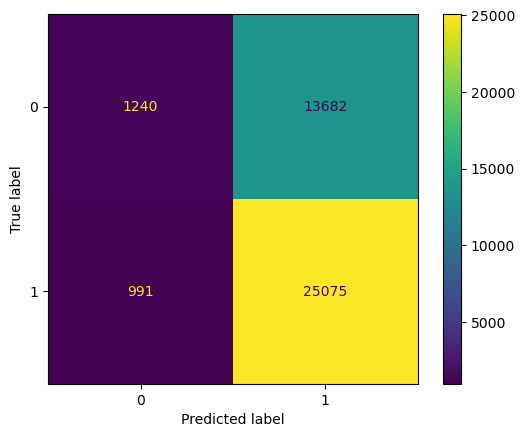

In [95]:
model_evaluation_dict_gender['Model_Name'].append('Stacking_Classifier')
evaluate_model(sclf_fit,X_train_s2, Y_train_s2_gender)

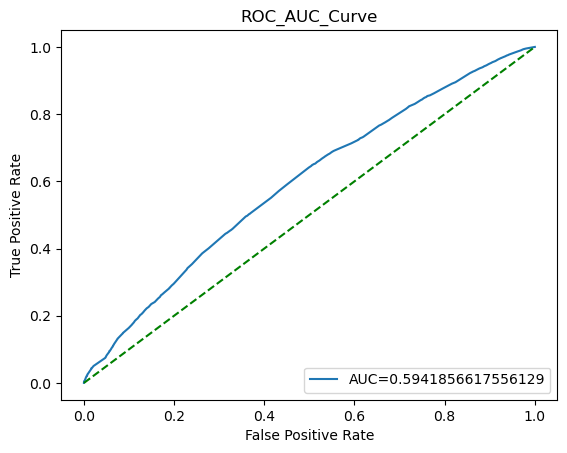

In [96]:
#Calculating the auc score and plotting it for Train Data
auc = plot_and_get_roc_auc_curve(sclf_fit, X_train_s2, Y_train_s2_gender)
model_evaluation_dict_gender['AUC_Training'].append(auc)

#### Evaluating the Stacking Classifier Model on Test Data Set

Evaluating Testing performance
Accuracy:0.5159193286886687
Precision:0.5942326400585264
Recall:0.6368159203980099
F1Score:0.7708217913204061
KS statistic for class Female: KstestResult(statistic=0.6360355087308556, pvalue=0.0)
KS statistic for class Male: KstestResult(statistic=0.6360355087308556, pvalue=0.0)


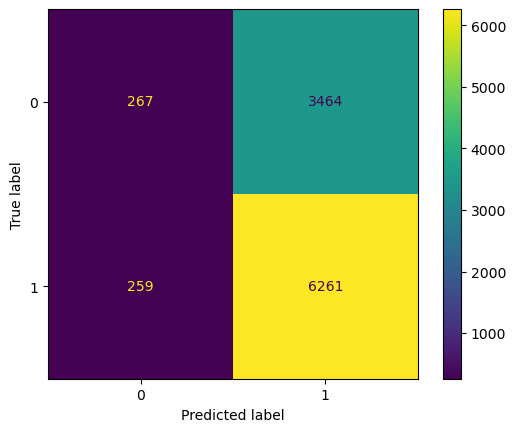

In [97]:
evaluate_model(sclf_fit, X_test_s2, Y_test_s2_gender, False)

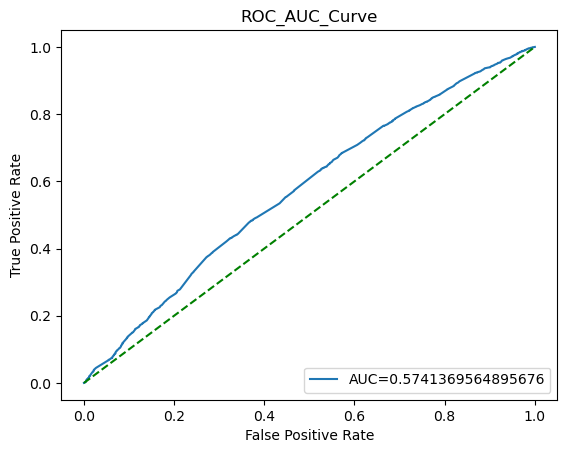

In [98]:
#Calculating the auc score and plotting it for Test Data
auc = plot_and_get_roc_auc_curve(sclf_fit, X_test_s2, Y_test_s2_gender)
model_evaluation_dict_gender['AUC_Testing'].append(auc)

### HyperParemter Tuning Stacking Classifier for Predicting `Gender` for Scenario 2

In [63]:
# Classification Models for Stacking Classifier Model
clf1 = LogisticRegression(class_weight = class_weights)
clf2 = RandomForestClassifier(class_weight = class_weights,n_jobs=-1)

# Meta Classifier for Stacking Classifer Model
xgb_m = xgb.XGBClassifier()

In [64]:
#Creating the Stacking Classifier
stacking_classifier_hpt = StackingCVClassifier(classifiers=[clf1, clf2], meta_classifier=xgb_m, use_probas=True, cv=cross_validation, random_state=100)

In [66]:
#Creating parameter grid
param_grid = {
    'randomforestclassifier__max_features':['sqrt','log2'],
    'randomforestclassifier__n_estimators': [100, 200, 300, 1000],
    'randomforestclassifier__max_depth':range(1,50,5),
    'randomforestclassifier__min_samples_leaf':range(50,350,50),
    'randomforestclassifier__min_samples_split':range(50,350,50),
    'randomforestclassifier__criterion':['gini','entropy'],
    'logisticregression__C': [0.1, 0.5,2],
    'logisticregression__max_iter': [2000],
    'meta_classifier__n_estimators': [100, 200, 300],
    'meta_classifier__learning_rate': [0.01, 0.1, 0.3],
    'meta_classifier__min_child_weight':[1, 5, 10],
    'meta_classifier__gamma': [0.5, 1, 1.5, 2, 5],
    'meta_classifier__subsample': [0.6, 0.8, 1.0],
    'meta_classifier__colsample_by_tree': [0.6, 0.8, 1.0],
    'meta_classifier__max_depth': [3, 4, 5],
}

In [67]:
#Hyperparmeter Tuning
stacking_classifier_cv_hpt = RandomizedSearchCV(stacking_classifier_hpt,
                              param_grid,
                               cv=cross_validation,
                               scoring='accuracy',
                               verbose=4,
                               n_jobs=-1,
                               random_state = 100,
                               error_score="raise")
stacking_classifier_cv_hpt.fit(X_train_s2, Y_train_s2_gender)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[14:37:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "colsample_by_tree" } are not used.



RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   error_score='raise',
                   estimator=StackingCVClassifier(classifiers=[LogisticRegression(class_weight={0: 1.3734083902962069,
                                                                                                1: 0.7862349420701297}),
                                                               RandomForestClassifier(class_weight={0: 1.3734083902962069,
                                                                                                    1: 0.7862349420701297},
                                                                                      n_jobs=-1)],
                                                  cv=StratifiedKFold(n_splits=5, random_s...
                                        'randomforestclassifier__criterion': ['gini',
                                                                              'entropy'],
                                        'randomforestclassifier__max_depth': range(1, 50, 5),
                                        'randomforestclassifier__max_features': ['sqrt',
                                                                                 'log2'],
                                        'randomforestclassifier__min_samples_leaf': range(50, 350, 50),
                                        'randomforestclassifier__min_samples_split': range(50, 350, 50),
                                        'randomforestclassifier__n_estimators': [100,
                                                                                 200,
                                                                                 300,
                                                                                 1000]},
                   random_state=100, scoring='accuracy', verbose=4)

In [68]:
print(stacking_classifier_cv_hpt.best_params_)
print(stacking_classifier_cv_hpt.best_score_)
print(stacking_classifier_cv_hpt.best_estimator_)
best_stacking_classifier = stacking_classifier_cv_hpt.best_estimator_

{'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__min_samples_split': 50, 'randomforestclassifier__min_samples_leaf': 250, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__max_depth': 11, 'randomforestclassifier__criterion': 'gini', 'meta_classifier__subsample': 0.6, 'meta_classifier__n_estimators': 100, 'meta_classifier__min_child_weight': 5, 'meta_classifier__max_depth': 4, 'meta_classifier__learning_rate': 0.01, 'meta_classifier__gamma': 2, 'meta_classifier__colsample_by_tree': 0.6, 'logisticregression__max_iter': 2000, 'logisticregression__C': 0.1}
0.6400165561972747
StackingCVClassifier(classifiers=[LogisticRegression(C=0.1,
                                                     class_weight={0: 1.3734083902962069,
                                                                   1: 0.7862349420701297},
                                                     max_iter=2000),
                                  RandomForestClassifier(class_weig

In [72]:
# Saving the Stacking Classifier Model as a pickle in a file
path = 'E:\\Shobhit\\MSDS\\Capstone\\Y1_Capstone\\MLModels'
filename = f'{path}\\Stacking_Classifier_HPT_Gender_Scenario2.pkl'
pickle.dump(best_stacking_classifier, open(filename, 'wb'))

In [ ]:
# Reading saved Hyper Paramter Tuned Stacking Classifier model
# path = 'E:\\Shobhit\\MSDS\\Capstone\\Y1_Capstone\\MLModels'
# filename = f'{path}\\Stacking_Classifier_HPT_Gender_Scenario2.pkl'
# best_stacking_classifier = pickle.load(open(filename, 'rb'))
# print(best_stacking_classifier)

#### Evaluating the Stacking Classifier on Training Data Set

Evaluating Training performance
Accuracy:0.527005411901061
Precision:0.6169996014513287
Recall:0.6436518005269835
F1Score:0.7733606430189617
KS statistic for class Female: KstestResult(statistic=0.6359422269932663, pvalue=0.0)
KS statistic for class Male: KstestResult(statistic=0.6359422269932663, pvalue=0.0)
Top 3 deciles:
   y_true  y_scores  decile  min_prob  max_prob  cum_event_pct  \
9       1  0.595631       5  0.632390  0.683931       0.000153   
8       1  0.593568       5  0.624931  0.631622       0.000115   
7       1  0.549737       1  0.615622  0.624834       0.000038   

   cum_nonevent_pct        KS  
9         -1.746147  1.746300  
8         -1.529085  1.529200  
7         -1.331859  1.331897  
Bottom 3 deciles:
   y_true  y_scores  decile  min_prob  max_prob  cum_event_pct  \
0       1  0.595631       5  0.367160  0.542350       0.000038   
1       1  0.607029       6  0.542599  0.551823       0.000038   
2       1  0.635961       9  0.552085  0.563615       0.000038   

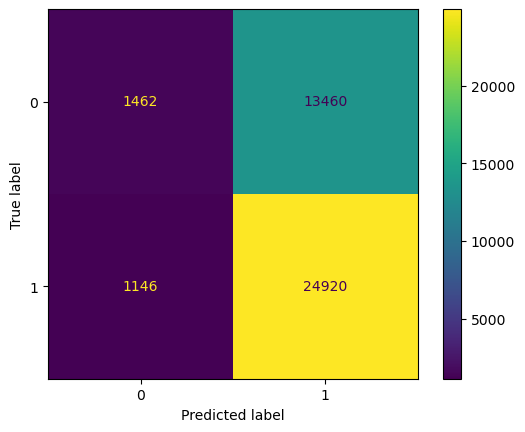

In [99]:
model_evaluation_dict_gender['Model_Name'].append('Stacking_Classifier_HPT')
evaluate_model(best_stacking_classifier, X_train_s2, Y_train_s2_gender)

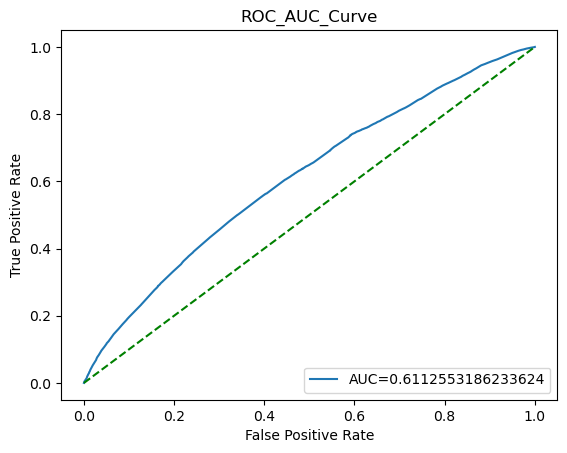

In [100]:
#Calculating the auc score and plotting it for Train Data
auc = plot_and_get_roc_auc_curve(best_stacking_classifier, X_train_s2, Y_train_s2_gender)
model_evaluation_dict_gender['AUC_Training'].append(auc)

#### Evaluating the Stacking classifier on Test Data Set

Evaluating Testing performance
Accuracy:0.5199134921639784
Precision:0.5955553982948267
Recall:0.6370110233147985
F1Score:0.7690684540433191
KS statistic for class Female: KstestResult(statistic=0.6360355087308556, pvalue=0.0)
KS statistic for class Male: KstestResult(statistic=0.6360355087308556, pvalue=0.0)


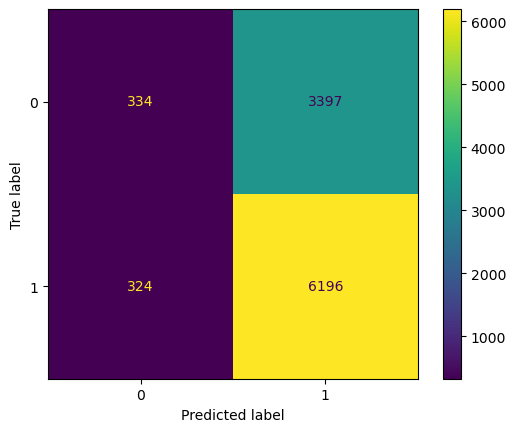

In [101]:
evaluate_model(best_stacking_classifier, X_test_s2, Y_test_s2_gender, False)

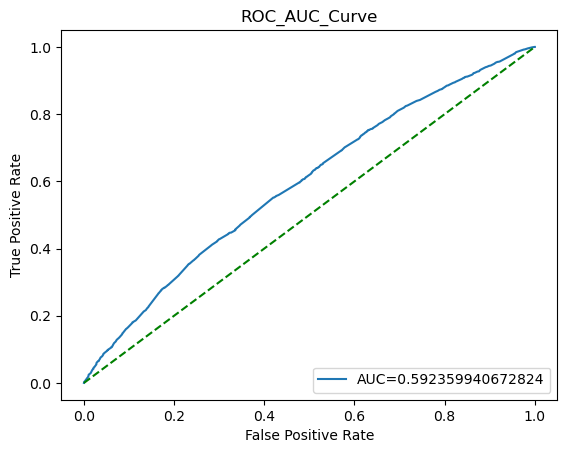

In [102]:
#Calculating the auc score and plotting it for Test Data
auc = plot_and_get_roc_auc_curve(best_stacking_classifier, X_test_s2, Y_test_s2_gender)
model_evaluation_dict_gender['AUC_Testing'].append(auc)

### Evaluation Metrics

In [103]:
model_evaluation_dict_gender

{'Model_Name': ['Logistic_Regression',
  'XGBoost_Basic',
  'XGBoost_HPT',
  'Stacking_Classifier',
  'Stacking_Classifier_HPT'],
 'Training_Accuracy': [0.5888217955856965,
  0.519826196557144,
  0.5129513461250705,
  0.5225399525806528,
  0.527005411901061],
 'Testing_Accuracy': [0.5655741236169187,
  0.5143465131307418,
  0.5129513461250705,
  0.5159193286886687,
  0.5199134921639784],
 'Precision_Training': [0.6176790235582619,
  0.6507657231377372,
  0.6361159331478019,
  0.6137868133712342,
  0.6169996014513287],
 'Precision_Testing': [0.5966103339623141,
  0.6298629673502186,
  0.6361159331478019,
  0.5942326400585264,
  0.5955553982948267],
 'Recall_Training': [0.6027129891675612,
  0.6458719625256173,
  0.6417910447761194,
  0.6420171757587586,
  0.6436518005269835],
 'Recall_Testing': [0.5822846551555946,
  0.6418885962345137,
  0.6417910447761194,
  0.6368159203980099,
  0.6370110233147985],
 'F1Score_Training': [0.6719845298525502,
  0.7793502880683459,
  0.7779390420899855,

In [104]:
df_evaluation_gender_s2 = pd.DataFrame(model_evaluation_dict_gender)
df_evaluation_gender_s2

,Model_Name,Training_Accuracy,Testing_Accuracy,Precision_Training,Precision_Testing,Recall_Training,Recall_Testing,F1Score_Training,F1Score_Testing,AUC_Training,AUC_Testing,KS_Training_Male,KS_Testing_Male,KS_Training_Female,KS_Testing_Female,Top3_Probability_Bands_KSTable,Bottom3_Probability_Bands_KSTable
0,Logistic_Regression,0.588822,0.565574,0.617679,0.596610,0.602713,0.582285,0.671985,0.656285,0.631681,0.592779,"(0.6359422269932663, 0.0)","(0.6360355087308556, 0.0)","(0.6359422269932663, 0.0)","(0.6360355087308556, 0.0)","[[0.6254049458716897, 0.9044765466039638], [0....","[[0.09301092983826001, 0.3686872687026987], [0..."
1,XGBoost_Basic,0.519826,0.514347,0.650766,0.629863,0.645872,0.641889,0.779350,0.777394,0.606783,0.589095,"(0.6359422269932663, 0.0)","(0.6360355087308556, 0.0)","(0.6359422269932663, 0.0)","(0.6360355087308556, 0.0)","[[0.7074506878852844, 0.9010139107704163], [0....","[[0.1645386517047882, 0.5426547527313232], [0...."
2,XGBoost_HPT,0.512951,0.512951,0.636116,0.636116,0.641791,0.641791,0.777939,0.777939,0.589066,0.589066,"(0.6360355087308556, 0.0)","(0.6360355087308556, 0.0)","(0.6360355087308556, 0.0)","(0.6360355087308556, 0.0)","[[0.7066282629966736, 0.8342078328132629], [0....","[[0.328716516494751, 0.5459055304527283], [0.5..."
3,Stacking_Classifier,0.522540,0.515919,0.613787,0.594233,0.642017,0.636816,0.773645,0.770822,0.594186,0.574137,"(0.6359422269932663, 0.0)","(0.6360355087308556, 0.0)","(0.6359422269932663, 0.0)","(0.6360355087308556, 0.0)","[[0.7464618682861328, 0.9606512784957886], [0....","[[0.08358228206634521, 0.5464363098144531], [0..."
4,Stacking_Classifier_HPT,0.527005,0.519913,0.617000,0.595555,0.643652,0.637011,0.773361,0.769068,0.611255,0.592360,"(0.6359422269932663, 0.0)","(0.6360355087308556, 0.0)","(0.6359422269932663, 0.0)","(0.6360355087308556, 0.0)","[[0.6323898434638977, 0.6839312314987183], [0....","[[0.36715957522392273, 0.542350172996521], [0...."


In [106]:
path = 'E:\\Shobhit\\MSDS\\Capstone\\Y1_Capstone\\MLModels'
df_evaluation_gender_s2.to_csv(f'{path}\\evaluation_metrics_gender_s2.csv',index=False)